Data: https://opus.nlpl.eu/opus-100.php

In [1]:
import os
import time
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch.nn.utils.rnn import pad_sequence

In [2]:
from modules.data import Vocabulary, PolEngDS, get_loader
from modules.model import Model

In [3]:
@dataclass
class Config:
    epochs:int = 20
    learning_rate:float = 3e-4
    batch_size:int = 32
    limit:int = 100000
    max_length:int = 50
    embed_size:int = 256
    num_layers:int = 3
    heads:int = 8
    forward_expansion:int = 4
    dropout:int = 0.15
        
config = Config()

In [4]:
@dataclass
class paths:
    data = os.path.join('data', 'en-pl')
    pl_test = os.path.join(data, 'opus.en-pl-test.pl')
    en_test = os.path.join(data, 'opus.en-pl-test.en')
    pl_dev = os.path.join(data, 'opus.en-pl-dev.pl')
    en_dev = os.path.join(data, 'opus.en-pl-dev.en')
    pl_train = os.path.join(data, 'opus.en-pl-train.pl')
    en_train = os.path.join(data, 'opus.en-pl-train.en')

In [5]:
train_data = PolEngDS(
    pl_path=paths.pl_train, 
    en_path=paths.en_train, 
    limit=config.limit
)

vocab_pl = train_data.vocab_pl
vocab_en = train_data.vocab_en

### Data analysis

In [6]:
lens_pl = train_data.data['polish'].apply(lambda x: len(x.split())).values
lens_en = train_data.data['english'].apply(lambda x: len(x.split())).values

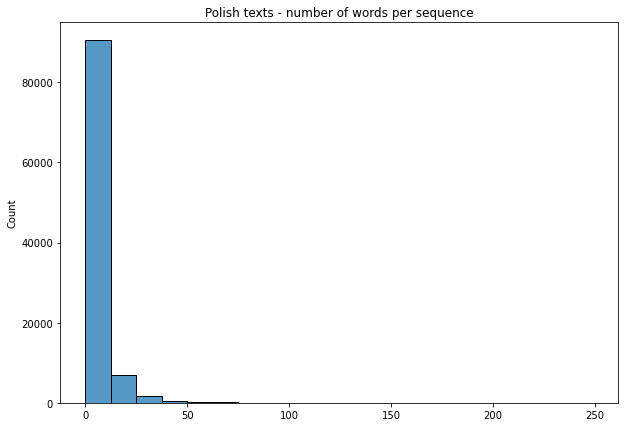

Percentile 98%: 27.0


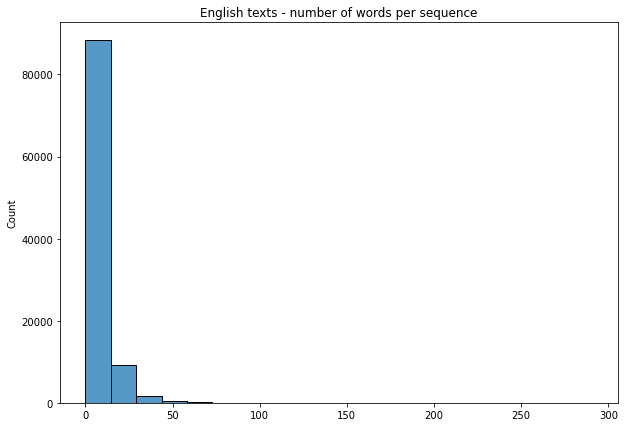

Percentile 98%: 32.0


In [7]:
plt.figure(figsize=(10, 7))
plt.title('Polish texts - number of words per sequence')
sns.histplot(lens_pl, bins=20)
plt.show()
print(F'Percentile 98%: {np.percentile(lens_pl, 98)}')

plt.figure(figsize=(10, 7))
plt.title('English texts - number of words per sequence')
sns.histplot(lens_en, bins=20)
plt.show()
print(F'Percentile 98%: {np.percentile(lens_en, 98)}')

### ...

In [8]:
train_loader = get_loader(data=train_data, batch_size=config.batch_size)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = Model(
    src_vocab_size=len(vocab_pl),
    trg_vocab_size=len(vocab_en),
    src_pad_idx=vocab_pl['<pad>'],
    trg_pad_idx=vocab_en['<pad>'],
    embed_size=config.embed_size,
    num_layers=config.num_layers,
    heads=config.heads,
    forward_expansion=config.forward_expansion,
    dropout=config.dropout,
    max_length=config.max_length,
    device=device
)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_en['<pad>'])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.1,
    patience=5,
    verbose=True
)

In [12]:
wandb.init(
    project=f'PolEng translation - {time.time()}', 
    config=config.__dict__
)

In [13]:
wandb.watch(model, log_freq=50)

In [14]:
def train_epoch(model, loader, epoch, device=device):
    model.train()
    
    losses = []
    t0 = time.time()
    t_batch = t0
    
    for batch_idx, (src, trg) in enumerate(loader):
        src = src.to(device)
        trg = trg.to(device)

        scores = model(src, trg[:, :-1])
        
        loss = criterion(
            scores.reshape(-1, scores.shape[2]), 
            trg[:, 1:].reshape(-1).type(torch.long)
        )
        
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()
        
        if (batch_idx + 1) % int(len(loader) / 5) == 0:
            print('Epoch: {epoch}, batch: {batch_idx}/{no_batches}, loss: {loss:.3f}, time: {t:.2f}'.format(
                epoch=epoch+1,
                batch_idx=batch_idx,
                no_batches=len(loader),
                loss=sum(losses)/len(losses),
                t=time.time()-t_batch
                )
            )
            
            t_batch = time.time()
        
    loss = sum(losses) / len(losses)
    
    scheduler.step(loss)
    
    print('Epoch: {epoch}, loss: {loss:.3f}, time: {t:.2f}'.format(
        epoch=epoch+1, 
        loss=loss, 
        t=time.time()-t0
        )
    )
    
    return loss

In [15]:
loss = []

for epoch in range(config.epochs):
    l = train_epoch(model, train_loader, epoch)
    loss.append(l)
    
    torch.save({
        'epoch': epoch,
        'model_sd': model.state_dict(),
        'optimizer_sd': optimizer.state_dict(),
        'loss': loss
       }, f'./models/checkpoint-{epoch}.pt')
    
    wandb.log({
        'loss': l
    })

In [16]:
def translate(
    sentence_pl, 
    model=model, 
    vocab_pl=vocab_pl, 
    vocab_en=vocab_en, 
    device=device, 
    max_length=50
):
    
    sentence_pl = [vocab_pl[word] for word in PolEngDS._text_prep(sentence_pl).split()]
    sentence_pl = [vocab_pl['<sos>'], *sentence_pl, vocab_pl['<eos>']]
    sentence_pl = torch.IntTensor(sentence_pl).unsqueeze(0)
    
    print(sentence_pl)
    
    outputs = [vocab_en['<sos>']]
    
    model.eval()
    for i in range(max_length):
        sentence_en = torch.IntTensor(outputs).unsqueeze(0)
    
        with torch.no_grad():
            output = model(sentence_pl, sentence_en)
            
        prediction = output.argmax(2)[:, -1].item()
        outputs.append(prediction)

        if prediction == vocab_en['<eos>']:
            break
    
    sentence_en = [vocab_en[word] for word in outputs]
    
    model.train()
    
    return sentence_en[1:]